# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [1]:
NAME = "GIN-12"
COLLABORATORS = "Anna Staniszewska, Zuzanna Słobodzian, Rafał Żegleń"

---

## Zestaw zadań 4: Badanie relacji między punktami (część 1)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")

In [3]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
# YOUR CODE HERE
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    expected_value = intensity*(x_lim[1]-x_lim[0])*(y_lim[1]-y_lim[0])
    n = np.random.poisson(expected_value)
   
    x = np.random.uniform(x_lim[0],x_lim[1],n)
    y = np.random.uniform(y_lim[0],y_lim[1],n)
    
    array = pd.DataFrame(data={"X":x.flatten(), "Y":y.flatten()})
    
    return array

def unhomogeneous_poisson_on_rectangle(intensity_function, x_lim, y_lim):
    def temp(x):
        return -f(x[0], x[1])
    
    intensity_max = -sp.optimize.minimize(temp, [(x_lim[0]+x_lim[1])/2, (y_lim[0]+y_lim[1])/2], bounds = [x_lim, y_lim]).fun
    
    n_array = homogeneous_poisson_on_rectangle(intensity_max, x_lim, y_lim)
    
    i_max = intensity_max
    for i in range(len(n_array)):
        if np.random.rand()<(1-f(n_array["X"][i],n_array["Y"][i])/i_max):
            n_array = n_array.drop(i)
            i-=1
    
    return n_array
    
def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    d_x = (x_lim[1]-x_lim[0])/grid[0]
    d_y = (y_lim[1]-y_lim[0])/grid[1]

    vector_x = np.linspace(x_lim[0]+1/2*d_x, x_lim[1]-1/2*d_x, grid[0])
    vector_y = np.linspace(y_lim[0]+1/2*d_y, y_lim[1]-1/2*d_y, grid[1])
                                                                                                                                                                                    
    matrix_x, matrix_y = np.meshgrid(vector_x, vector_y)
    
    rand_x = np.random.rand(grid[1], grid[0])*d_x-1/2*d_x
    rand_y = np.random.rand(grid[1], grid[0])*d_y-1/2*d_y

    rand_x = random_component*rand_x
    rand_y = random_component*rand_y
    
    matrix_x += rand_x
    matrix_y += rand_y
        
    array = pd.DataFrame(data={"X":matrix_x.flatten(), "Y":matrix_y.flatten()})
    
    return array

def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    x_lim[0] -= cluster_radius
    x_lim[1] += cluster_radius
    y_lim[0] -= cluster_radius
    y_lim[1] += cluster_radius
    
    parent_array = homogeneous_poisson_on_rectangle(parent_intensity, x_lim, y_lim)
    
    x_circle = np.empty((1,1))
    y_circle = np.empty((1,1))

    for i in range(0, len(parent_array)):
        expected_value_m = daughter_intensity*cluster_radius**2*np.pi
        m_daughter = np.random.poisson(expected_value_m)      
        for j in range(0, m_daughter):
                x = np.random.uniform(parent_array['X'][i]-cluster_radius, parent_array['X'][i]+cluster_radius)
                y = np.random.uniform(-(cluster_radius**2-(x-parent_array['X'][i])**2)**(1/2)+parent_array['Y'][i], (cluster_radius**2-(x-parent_array['X'][i])**2)**(1/2)+parent_array['Y'][i])
                x_circle = np.append(x_circle, x)
                y_circle = np.append(y_circle, y)
                
    m = 0
    while(True):
        if x_circle[m]<(x_lim[0]+cluster_radius) or x_circle[m]>(x_lim[1]-cluster_radius)or y_circle[m]<(y_lim[0]+cluster_radius) or y_circle[m]>(y_lim[1]-cluster_radius):
            x_circle = np.delete(x_circle, m)
            y_circle = np.delete(y_circle, m)
            m-=1
        m+=1
        if m == len(x_circle):
            break
            
    array = pd.DataFrame(data={"X":x_circle, "Y":y_circle})

    return array
#raise NotImplementedError()

### Przygotowanie danych (5 pkt)

Korzystając z funkcji przygotowanych w ramach pierwszego zestawu zadań wygeneruj rozkłady punktowe o podanych paramatrach.

Jednorodny rozkład Poissona:
 - intensywność procesu: 2.5

Rozkład regularny z komponentem losowym:
- liczba punktów w poziomie i w pionie: 15x15
- komponent losowy: 0.75

Rozkład Materna:
 - intensywność procesu macierzystego: 0.3
 - intensywność procesu potomnego: 5
 - promień klastra: 0.75
 
Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [0, 10]
 - zakres wartości współrzędnej y: [0, 10]

In [4]:
# YOUR CODE HERE
poisson = homogeneous_poisson_on_rectangle(2.5, [0,10], [0,10])
regular = regular_on_rectangle([15,15], 0.75, [0,10], [0,10])
materna = materna_on_rectangle(0.3, 5, 0.75, [0,10], [0,10])
#raise NotImplementedError()

### Zadanie 1: Wykres Morishity (25 pkt)

Przygotuj funkcję `morishita_plot_data()`, która będzie generować dane niezbędne do wykonania wykresu Morishity. 

Następnie wykorzystaj przygotowaną funkcję do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. Wykonaj obliczenia dla obszaru podzielonego na 2x2, 3x3, ... 40x40 podobszarów w poziomie i w pionie.

Przedstaw wyniki analizy graficznie w postaci wykresów punktówych zestawionych z rozkładami punktów na podstawie których zostały wykonane. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy Morishity w dolnym wierszu figury.

Algorytm postępowania:
1. Kolejno dzielimy obszar na rosnącą lub malejącą liczbę kwadratowych podobszarów.
2. Dla każdego z podziałów obliczamy wartość indeksu: <br/>
$MI = L \sum_{i=1}^L \frac{n_i (n_i-1)}{N(N-1)}$ <br/>
gdzie: $L$ - liczba podobszarów, $N$ - liczba punktów, $n_i$ - liczba punktów w obrębie i-tego podobszaru.
3. Zestawiamy w tabeli długości boków podobszarów w poszczególnych podziałach z obliczonymi dla nich wartości indeksu $MI$.

#### a) Przygotowanie funkcji

In [5]:
def morishita_plot_data(points, bins_list, x_lim, y_lim):

    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins_list: list
        Lista zawierająca wszystkie zestawy parametrów określających liczbę podobszarów w poziomie i pionie, dla których mają zostać przeprowadzone obliczenia.
        Przykład: [[2, 2], [4, 4], [8, 8], [16, 16]]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10] 
    
    Returns
    -------
    morishita_index: DataFrame
        Tablica zawierająca dwie kolumny:
        - "BD" - długości boków podobszarów,
        - "MI" - wyliczone wartości indeksów MI.
    """
    # YOUR CODE HERE
    len_list = len(bins_list)

    N = len(points["X"])
    MI = np.zeros(len_list)
    BD = np.zeros(len_list)
        
    for i in range(0, len_list):
        BD[i] = (x_lim[1]-x_lim[0])/bins_list[i][0]

        count_points = np.histogram2d(points['X'], points['Y'], bins_list[i], [x_lim, y_lim])    
        ni = count_points[0].T.flatten() 
        
        MI[i] = bins_list[i][0]*bins_list[i][1]*np.sum((ni*(ni-1))/(N*(N-1)))
        
    m_array = pd.DataFrame(data={"BD":BD, "MI":MI})

    return m_array
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [6]:
# YOUR CODE HERE
bins_list = []
for i in range(2, 41):
    bins_list.append([i, i])
    
m_poisson = morishita_plot_data(poisson, bins_list, [0, 10], [0, 10])
m_regular = morishita_plot_data(regular, bins_list, [0, 10], [0, 10])
m_materna = morishita_plot_data(materna, bins_list, [0, 10], [0, 10])
#raise NotImplementedError()

#### c) Wizualizacja

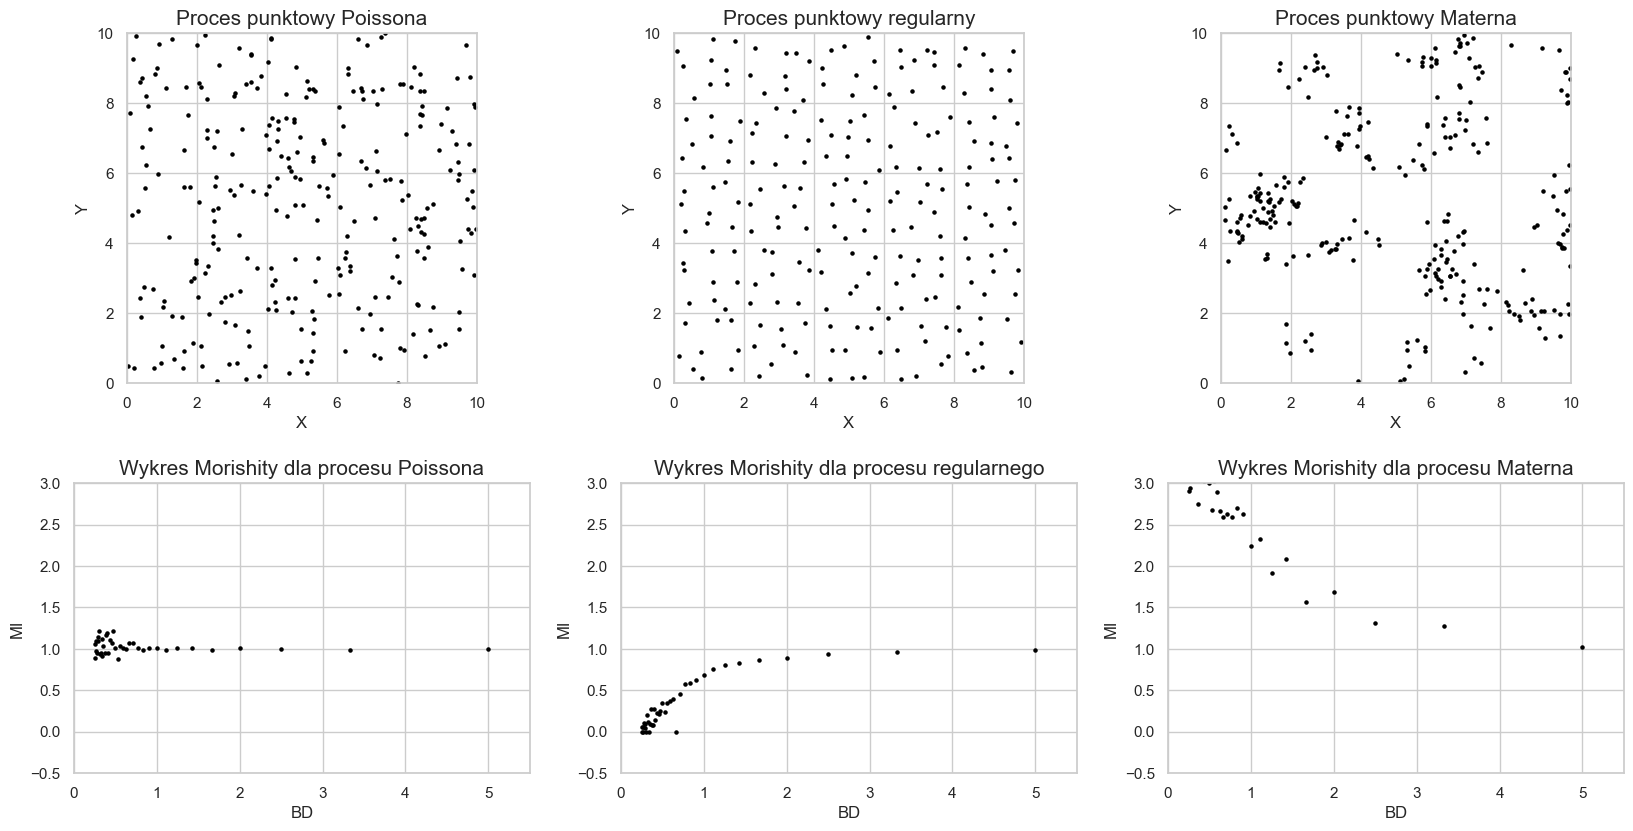

In [7]:
# YOUR CODE HERE
fig,axs=plt.subplots(2,3,figsize=(20,10))
axs[0,0].scatter(poisson["X"],poisson["Y"],s=5,c="black")
axs[0,1].scatter(regular["X"],regular["Y"],s=5,c="black")
axs[0,2].scatter(materna["X"],materna["Y"],s=5,c="black")
axs[0,0].set_title("Proces punktowy Poissona",size=15)
axs[0,1].set_title("Proces punktowy regularny",size=15)
axs[0,2].set_title("Proces punktowy Materna",size=15)
for j in range(3):
    axs[0,j].axis("square")
    axs[0,j].set_xlim(0,10)
    axs[0,j].set_ylim(0,10)
    axs[0,j].set_xlabel("X")
    axs[0,j].set_ylabel("Y")
    
axs[1,0].scatter(m_poisson["BD"],m_poisson["MI"],s=5,c="black")
axs[1,1].scatter(m_regular["BD"],m_regular["MI"],s=5,c="black")
axs[1,2].scatter(m_materna["BD"],m_materna["MI"],s=5,c="black")
axs[1,0].set_title("Wykres Morishity dla procesu Poissona",size=15)
axs[1,1].set_title("Wykres Morishity dla procesu regularnego",size=15)
axs[1,2].set_title("Wykres Morishity dla procesu Materna",size=15)
for j in range(3):
    axs[1,j].axis("square")
    axs[1,j].set_xlim(0,5.5)
    axs[1,j].set_ylim(-0.5,3)
    axs[1,j].set_xlabel("BD")
    axs[1,j].set_ylabel("MI")


#raise NotImplementedError()

### Zadanie 2: Wykres Fry (20 pkt)

Przygotuj funkcję `fry_plot_data()`, która będzie generować dane niezbędne do wykonania wykresu Morishity.

Następnie wykorzystaj przygotowaną funkcję do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Przedstaw wyniki analizy graficznie w postaci wykresów punktowych zestawionych z rozkładami punktów na podstawie których zostały wykonane. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3). Umieść analizowane rozkłady punktów w górnym wierszu, a wykresy Fry w dolnym wierszu figury.

Algorytm postępowania: <br/>
Traktując kolejno każdy punkt analizowanego rozkładu jako początek układu współrzędnych zapisujemy współrzędne pozostałych punktów względem niego.
Rezultatem jest zbiór współrzędnych $n(n-1)$ punktów, gdzie $n$ to liczba punktów w analizowanym rozkładzie.

#### a) Przygotowanie funkcji

In [9]:
def fry_plot_data(points):

    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    
    Returns
    -------
    fry_points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """    
    # YOUR CODE HERE
    length = len(points)
    
    temp_x = np.zeros(length)
    temp_y = np.zeros(length)

    new_x = []
    new_y = []

    for i in range(0, length):
        temp_x = points["X"] - points["X"][i]
        temp_y = points["Y"] - points["Y"][i]

        temp_x.pop(i)
        temp_y.pop(i)

        new_x = np.append(new_x, temp_x)
        new_y = np.append(new_y, temp_y)

    f_array = pd.DataFrame(data={"X":new_x, "Y":new_y})
    
    return f_array
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [10]:
# YOUR CODE HERE
f_poisson = fry_plot_data(poisson)
f_regular = fry_plot_data(regular)
f_materna = fry_plot_data(materna)
#raise NotImplementedError()

#### c) Wizualizacja

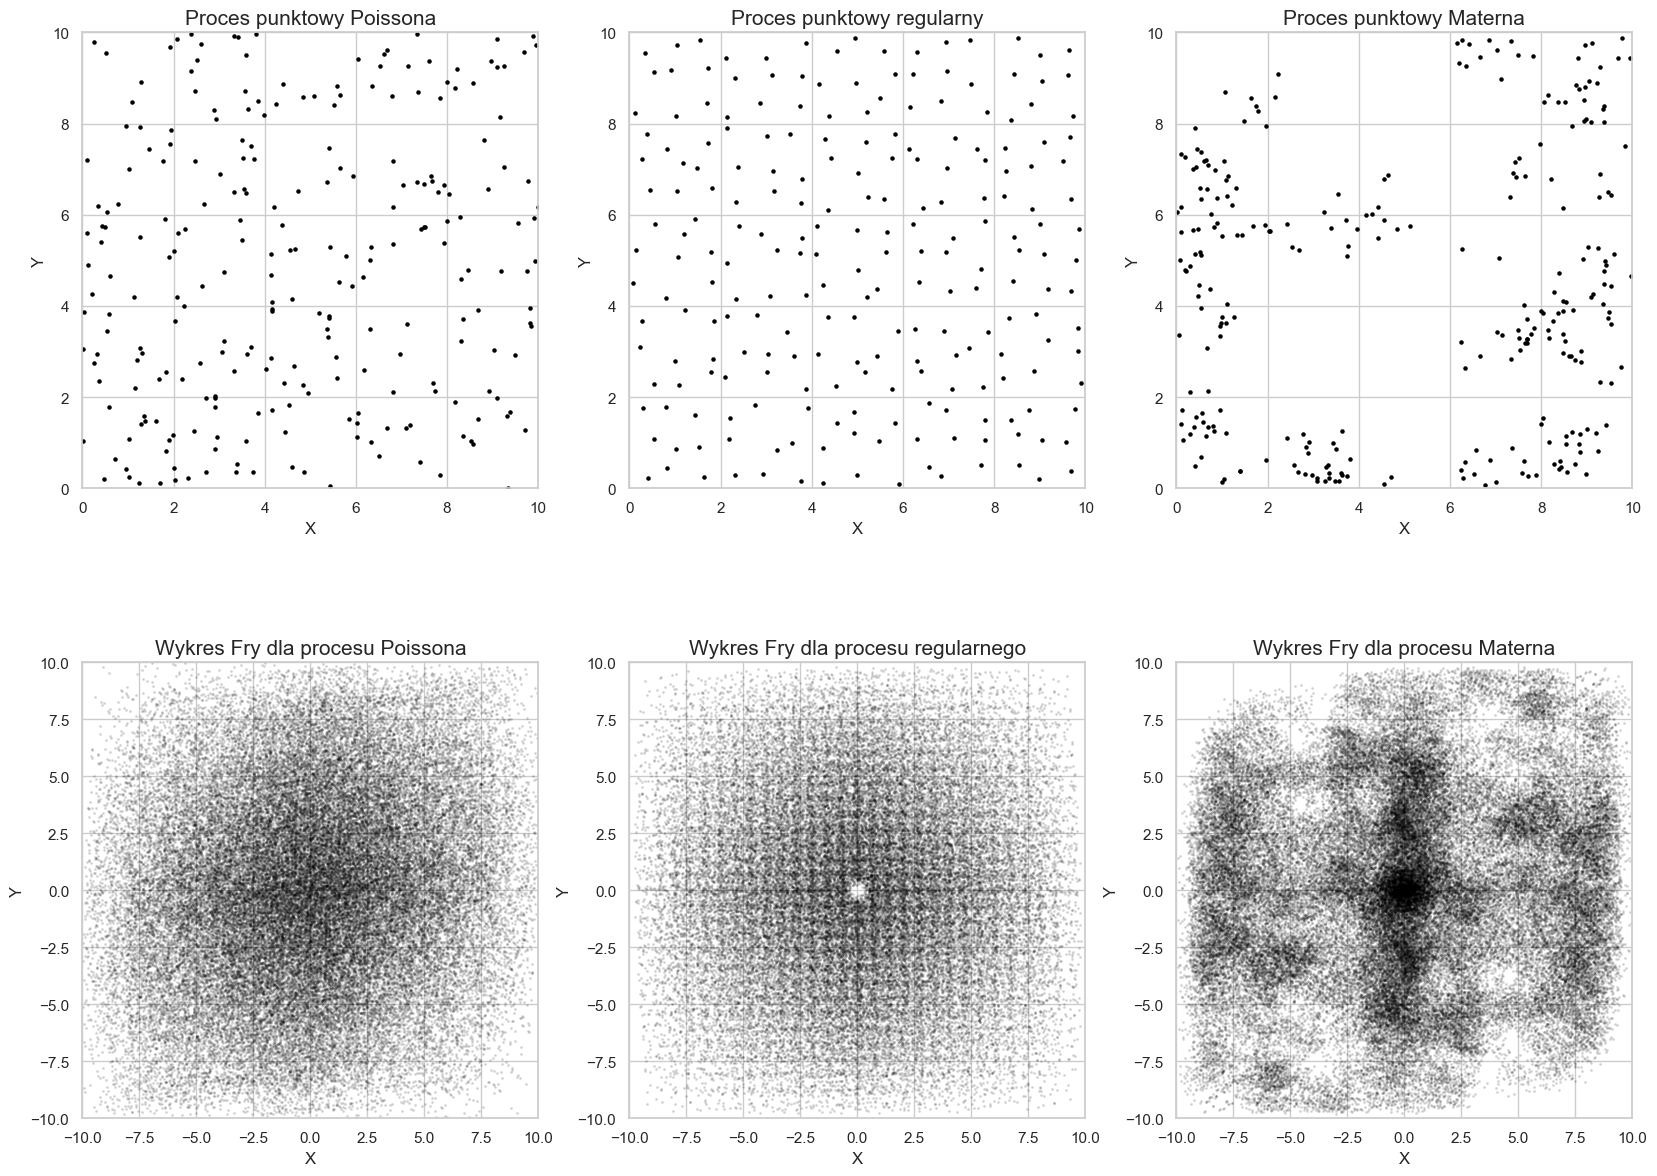

In [11]:
# YOUR CODE HERE
fig,axs=plt.subplots(2,3,figsize=(20,15))
axs[0,0].scatter(poisson["X"],poisson["Y"],s=5,c="black")
axs[0,1].scatter(regular["X"],regular["Y"],s=5,c="black")
axs[0,2].scatter(materna["X"],materna["Y"],s=5,c="black")
axs[0,0].set_title("Proces punktowy Poissona",size=15)
axs[0,1].set_title("Proces punktowy regularny",size=15)
axs[0,2].set_title("Proces punktowy Materna",size=15)
for j in range(3):
    axs[0,j].axis("square")
    axs[0,j].set_xlim(0,10)
    axs[0,j].set_ylim(0,10)
    axs[0,j].set_xlabel("X")
    axs[0,j].set_ylabel("Y")

axs[1,0].scatter(f_poisson["X"],f_poisson["Y"],s=1.5,c="black",alpha=0.1)
axs[1,1].scatter(f_regular["X"],f_regular["Y"],s=1.5,c="black",alpha=0.1)
axs[1,2].scatter(f_materna["X"],f_materna["Y"],s=1.5,c="black",alpha=0.1)
axs[1,0].set_title("Wykres Fry dla procesu Poissona",size=15)
axs[1,1].set_title("Wykres Fry dla procesu regularnego",size=15)
axs[1,2].set_title("Wykres Fry dla procesu Materna",size=15)
for j in range(3):
    axs[1,j].axis("square")
    axs[1,j].set_xlim(-10,10)
    axs[1,j].set_ylim(-10,10)
    axs[1,j].set_xlabel("X")
    axs[1,j].set_ylabel("Y")
#raise NotImplementedError()